# Features and elementary classification

Initialisation
- If reproducibility of results is needed, set the seed of the random number generator as needed

Data onboarding
- Load the data
- Find out how the data oriented and determine the sizes
- Visualise the data

Optional: Feature extraction

Data division
- Split the data for supervised learning

Feature selection
- Enumerate the feature combinations according to the desired number of features
- Evaluate the goodness of the combinations
- Choose the best or one of the best combinations
- Keep only the relevant/exclude the extra features
- Visualise the feature data

Optional: Data normalisation

Design the classifier
- Estimate the parameters of a linear classifier using the Perceptron cost **or** the least-squares method

Classify the samples in the test set

Performance evaluation
- Provide the classification accuracy
- Optional: study the confusion matrix

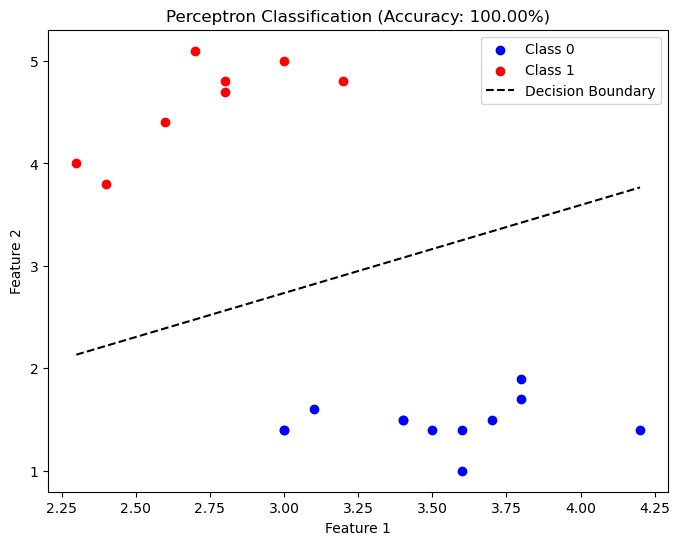

In [13]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load dataset
file_path = 'ws1_data1.csv'
data = pd.read_csv(file_path, header=None)

# Extracting features (columns 0 to 3) and labels (column 4)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Convert labels from (1, 2) to (0, 1) for binary classification
y = np.where(y == 1, 0, 1)

# Split data into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fisher Discriminant Ratio (FDR) function
def fisher_discriminant_ratio_multifeature(X, y):
    classes = np.unique(y)
    mean_diff = np.mean(X[y == classes[0]], axis=0) - np.mean(X[y == classes[1]], axis=0)
    cov1 = np.cov(X[y == classes[0]], rowvar=False)
    cov2 = np.cov(X[y == classes[1]], rowvar=False)
    cov_sum_inv = np.linalg.inv(cov1 + cov2)
    fdr = mean_diff.T @ cov_sum_inv @ mean_diff
    return fdr

# Enumerate all combinations of 2 features out of 4 features
num_features = X.shape[1]
feature_combinations = list(combinations(range(num_features), 2))

# Calculate FDR for each combination
fdr_values = []
for combo in feature_combinations:
    X_train_combo = X_train[:, combo]
    fdr = fisher_discriminant_ratio_multifeature(X_train_combo, y_train)
    fdr_values.append(fdr)

# Select the combination with the highest FDR
best_index = np.argmax(fdr_values)
best_features = feature_combinations[best_index]

# Select the best features
X_train_selected = X_train[:, best_features]
X_test_selected = X_test[:, best_features]

# Perceptron training
def perceptron_train_with_cost(X, y, epochs=1000, learning_rate=0.1):
    weights = np.zeros(X.shape[1] + 1)
    y_mod = np.where(y == 0, -1, 1)
    for _ in range(epochs):
        for i in range(len(X)):
            x_with_bias = np.insert(X[i], 0, 1)
            weighted_sum = np.dot(weights, x_with_bias)
            prediction = 1 if weighted_sum >= 0 else -1
            if prediction != y_mod[i]:
                weights += learning_rate * (y_mod[i] - prediction) * x_with_bias
    return weights

def perceptron_predict(X, weights):
    predictions = []
    for i in range(len(X)):
        x_with_bias = np.insert(X[i], 0, 1)
        weighted_sum = np.dot(weights, x_with_bias)
        prediction = 1 if weighted_sum >= 0 else -1
        predictions.append(prediction)
    return np.array(predictions)

# Train and predict with Perceptron
weights_perceptron = perceptron_train_with_cost(X_train_selected, y_train, epochs=1000, learning_rate=0.1)
y_pred_perceptron = perceptron_predict(X_test_selected, weights_perceptron)
y_pred_perceptron_original = np.where(y_pred_perceptron == 1, 1, 0)

# Calculate accuracy
accuracy_perceptron = accuracy_score(y_test, y_pred_perceptron_original)

# Plot the classification
plt.figure(figsize=(8, 6))
plt.scatter(X_test_selected[y_test == 0][:, 0], X_test_selected[y_test == 0][:, 1], color='blue', label='Class 0')
plt.scatter(X_test_selected[y_test == 1][:, 0], X_test_selected[y_test == 1][:, 1], color='red', label='Class 1')

# Plot decision boundary
x_vals = np.linspace(X_test_selected[:, 0].min(), X_test_selected[:, 0].max(), 100)
y_vals = -(weights_perceptron[0] + weights_perceptron[1] * x_vals) / weights_perceptron[2]
plt.plot(x_vals, y_vals, '--k', label='Decision Boundary')

plt.xlabel(f'Feature {best_features[0]}')
plt.ylabel(f'Feature {best_features[1]}')
plt.title(f'Perceptron Classification (Accuracy: {accuracy_perceptron * 100:.2f}%)')
plt.legend()
plt.show()
